In [134]:
import requests
import datetime
import pandas as pd
import numpy as np
import re
import sys
import requests
import json
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)    

from IPython.core.display import display, HTML
def display_side_by_side(dfs:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for df in dfs:
        
        output += df.style.set_table_attributes("style='display:inline;'")._repr_html_()
        output += "\xa0"
    display(HTML(output))

display(Markdown('''
# Cross Family Study on Ransomware
Currently, there is an innumerable amount of ransomware families, all with variations in name and linage. Often if source code is leaked or gangs rebrand, actions don't change. One way to study this is by gathering samples from MalwareBazaar tagged with Ransomware. By doing this, we can gather true positive samples to analyze and gather metrics on. In this case, we will compile a list of 250 binaries and cross-reference inside of VirusTotal.

_Note: The number of reports analyzed is arbitrary but can go up to 1000 due to MalwareBazaar's report limit._
'''))


# Cross Family Study on Ransomware
Currently, there is an innumerable amount of ransomware families, all with variations in name and linage. Often if source code is leaked or gangs rebrand, actions don't change. One way to study this is by gathering samples from MalwareBazaar tagged with Ransomware. By doing this, we can gather true positive samples to analyze and gather metrics on. In this case, we will compile a list of 250 binaries and cross-reference inside of VirusTotal.

_Note: The number of reports analyzed is arbitrary but can go up to 1000 due to MalwareBazaar's report limit._


# VirusTotal API Key

In [111]:
VTApiKey = "" 
if VTApiKey == "":
    display(Markdown("## Please enter your VirusTotal API Key"))

# MalwareBazaar API Key

In [112]:
BazaarApiKey = ""
if BazaarApiKey == "":
    display(Markdown("## Please enter your MalwareBazaar API Key"))

In [34]:
data= {'query': 'get_taginfo',
'tag': 'Ransomware',
'limit': "250"
}
headers = {
  'API-KEY': BazaarApiKey
}
response = requests.post( "https://mb-api.abuse.ch/api/v1/", headers=headers, data=data)
if response.status_code == 200:
    display(Markdown("#MalwareBazaar data received"))
else:
    str(response.status_code))
BazaarJsonobj = json.loads(response.text)

MalwareBazaar data received


In [123]:
display(Markdown('''

## Cleaning inflated Numbers
Before we move any further, we want to make sure our data set isn't inflated with one type of family. In this case, there was. The now-defunct GandCrab gang occupies a large majority of this data set to reduce it to around 20.
'''))
FamiliesIncluded = {}
Counter = 0
PositionInData = 0

for i in BazaarJsonobj["data"]:
    if i["signature"] != None:
        if i["signature"] == "GandCrab":
            if Counter < 20:
                FamiliesIncluded.update({i["signature"]:0})
                Counter += 1
            else: 
                BazaarJsonobj["data"].pop(PositionInData) # Keeps numbers down since the VT report grabber pulls from this list
        else:
            FamiliesIncluded.update({i["signature"]:0})
        PositionInData += 1

Counter = 0        
for i in BazaarJsonobj["data"]:
    if i["signature"] != None:
        if i["signature"] in FamiliesIncluded.keys():
            if i["signature"] == "GandCrab":
                if Counter < 20:
                    FamiliesIncluded.update({i["signature"]:FamiliesIncluded.get(i["signature"])+1})
                    Counter += 1
                else: pass
            else:
                FamiliesIncluded.update({i["signature"]:FamiliesIncluded.get(i["signature"])+1})
                
if None in FamiliesIncluded:
    FamiliesIncluded.pop(None)
    
FamiliesDF = pd.DataFrame(
    {
        "Family": FamiliesIncluded.keys(),
        "Count": FamiliesIncluded.values()
    }
)
FamiliesDF.sort_values(by=['Count'], inplace=True, ascending=False)
#print(json.dumps(FamiliesIncluded,indent=4))
FamiliesDF.style.hide_index()



## Cleaning inflated Numbers
Before we move any further, we want to make sure our data set isn't inflated with one type of family. In this case, there was. The now-defunct GandCrab gang occupies a large majority of this data set to reduce it to around 20.


Family,Count
GandCrab,20
Snatch,20
Babuk,13
Mespinoza,10
DoejoCrypt,7
Sodinokibi,5
Stop,4
Ryuk,3
Phobos,2
Clop,2


___

Once receiving the sample data, we will iterate through the list of returned hashes and request a behavior report from VirusTotal for each sample. Because of the query restrictions for free accounts on VirusTotal, a timer of 15 seconds is set to not cause problems for free VirusTotal API users. Fifty samples can be processed in VT in about 25 mins in this case, but this list and time can be scaled up or down if an account has a higher threshold for queries in a shorter period.

In [42]:
payload={}
files=[
]
headers = {
  'x-apikey': VTApiKey
}
behavioursList = []
for i in BazaarJsonobj["data"]:
    response = requests.request("GET","https://www.virustotal.com/api/v3/files/{}/behaviours".format(i["sha256_hash"]),headers=headers, data=payload, files=files)
    if response.status_code == 200:
        behavioursList.append(json.loads(response.text))
        print(str(response.status_code) + " " + i["sha256_hash"])
        time.sleep(15)
    else: 
        print(str(response.status_code))
    
if len(behavioursList) > 1:
    display(Markdown("# Attributes in list"))

200 a2b5ebfc52a447cde255e1ec1ac8797ad49b156ed427df8c292d6aeb4dad5523
200 b4be6b8acda97f36c448365751d5c9a9e1b91f47cedfde79e1de258413c3de71
200 678bfbf5d73d6cf38532e11b11dbed17668d94711e2e2ea27311dd46490201b7
200 2fdb9fa88fa2082583d32914c3863521604dd32218c26a0f35e0141ba35408b7
200 c373d37b5a9427a18dbf93d519968d9fda04f2a262f424d0611830764c8cc69c
200 c4282e9040cdc1df92b722568a8b4c42ce9f6533fed0bd34b7fdbae264947784
200 ed0f154481261e9a08dcc4f7e4d396bce75526811216106daa70d4148c660d76
200 92190c9789485a0d96bced7040080f0ae35c02898c3d31a65d50ecd659b80f09
200 7fee4cf62c39b0ea803bfe48775c5bd58755da836937ddd4bc0caafba08b4212
200 bb31f235e86b0fda185e6580ef5327f80d6a6c754f78499e8647de5e229769cc
200 18e299d4331ccff805275b21f33be0a3bd3d1d9ce72a79ba78d2f32dd657bfbb
200 6b7d70ca7d02133afbc24eeb585f2921bc35c01b23b90a66f515290c49cf0952
200 9bd421c6f7f7d8278036944fcad3e04db408619678acf1b2024ef69d85c3932b
200 98e3304a43402227458a979aad31e2ec1543c0c5d58c118d0a8fa8c70cc78d74
200 e395e96b17910ca97a5e2246829ff1

___

In [124]:
display(Markdown('''
Regarding ransomware the data we are interested in is:
- What data was written to disk?
- Can we derive any useful information from those locations?
- What, if any, processes were created?
- What kind of information gets returned from those commands?
___

One issue that will commonly come up as data is gathered from VirusTotal is the various styles in which it is presented. Some data will return the absolute path, while others will present data as environment variables. When this happens, we need the absolute path for data to be processed correctly. So to combat this, we can run the data through a number of regular expressions and replace as needed.
'''))
DroppedFiles = []
CommandExecutions = []
CommandDict = {}
for i in behavioursList:
    for j in i["data"]:
        if "files_dropped" in j["attributes"]:
            for k in j["attributes"]["files_dropped"]:
                if "path" in k:
                    x = re.search("^\/", k["path"])
                    if x:
                       pass
                    else:
                        translated = ""
                        if re.search(r"%APPDATA%", k["path"]):
                            translated = re.sub(r"%APPDATA%",r"c:\\users\\infected\\AppData\\Roaming", k["path"])
                        elif re.search(r"%LOCALAPPDATA%",k["path"]):
                            translated = re.sub(r"%LOCALAPPDATA%",r"c:\\users\\infected\\AppData\\Local", k["path"])
                        elif re.search(r"%HOMEPATH%",k["path"]):
                            ranslated = re.sub(r"%HOMEPATH%",r"c:\\users\\infected", k["path"])
                        elif re.search(r"%TEMP%", k["path"]):
                            translated = re.sub(r"%TEMP%",r"c:\\windows\\temp", k["path"])
                        elif re.search(r"%ALLUSERSPROFILE%", k["path"]):
                            translated = re.sub(r"%ALLUSERSPROFILE%",r"c:\\programdata", k["path"])
                        elif re.search(r"<SYSTEM32>", k["path"]):
                            translated = re.sub(r"<SYSTEM32>",r"c:\\windows\\system32", k["path"])
                        elif re.search(r"(%windir%|%WINDIR%)", k["path"]):
                            translated = re.sub(r"(%windir%|%WINDIR%)",r"c:\\windows", k["path"])
                        elif re.search(r"<USER>", k["path"]):
                            translated = re.sub(r"<USER>",r"infected", k["path"])
                        elif re.search(r"<DRIVERS>", k["path"]):
                            translated = re.sub(r"<DRIVERS>",r"c:\\windows\\system32\\Drivers", k["path"])
                        elif re.search(r"^C:\\", k["path"]) != True:
                            pass
                        elif re.search(r"(<CURRENT_DIR>|<PATH_SAMPLE>)", k["path"]):
                            pass              
                        else:
                            DroppedFiles.append(k["path"])
                        if translated != "":
                            DroppedFiles.append(translated.lower())
            if "files_written" in j["attributes"]:
                for k in j["attributes"]["files_written"]:
                    x = re.search("^\/", k)
                    if x:
                       pass
                    else:
                        translated = ""
                        if re.search(r"%APPDATA%", k):
                            translated = re.sub(r"%APPDATA%",r"c:\\users\\infected\\AppData\\Roaming", k)
                        elif re.search(r"%LOCALAPPDATA%",k):
                            translated = re.sub(r"%LOCALAPPDATA%",r"c:\\users\\infected\\AppData\\Local", k)
                        elif re.search(r"%HOMEPATH%",k):
                            ranslated = re.sub(r"%HOMEPATH%",r"c:\\users\\infected", k)
                        elif re.search(r"%TEMP%", k):
                            translated = re.sub(r"%TEMP%",r"c:\\windows\\temp", k)
                        elif re.search(r"%ALLUSERSPROFILE%", k):
                            translated = re.sub(r"%ALLUSERSPROFILE%",r"c:\\programdata", k)
                        elif re.search(r"<SYSTEM32>", k):
                            translated = re.sub(r"<SYSTEM32>",r"c:\\windows\\system32", k)
                        elif re.search(r"(%windir%|%WINDIR%)", k):
                            translated = re.sub(r"(%windir%|%WINDIR%)",r"c:\\windows", k)
                        elif re.search(r"<USER>", k):
                            translated = re.sub(r"<USER>",r"infected", k)
                        elif re.search(r"<DRIVERS>", k):
                            translated = re.sub(r"<DRIVERS>",r"c:\\windows\\system32\\Drivers", k)
                        elif re.search(r"^C:\\", k) != True:
                            pass
                        elif re.search(r"(<CURRENT_DIR>|<PATH_SAMPLE>)", k):
                            pass              
                        else:
                            DroppedFiles.append(k)
                        if translated != "":
                            DroppedFiles.append(translated.lower())
                            
DroppedFiles = list(dict.fromkeys(DroppedFiles)) #Remove Duplicates
FilesWritten = pd.DataFrame({"Files Written":DroppedFiles})


CommandLines = []
for i in behavioursList:
    for j in i["data"]:
        if "command_executions" in j["attributes"]:
            for k in j["attributes"]["command_executions"]:
                x = re.search("\(.+\.exe\)", k)
                z = re.search("(?<=commandline:)",k)
                if x:
                    split = re.split(r"(?<=\))\s",k)
                    CommandLines.append(split[1])
                elif z:
                    split = re.split(r"(?<=commandline:)\s",k)
                    CommandLines.append(split[1])
                else:
                    CommandLines.append(k)
                    
    for j in i["data"]:
        if "processes_created" in j["attributes"]:
            for k in j["attributes"]["processes_created"]:
                x = re.search("\(.+\.exe\)", k)
                z = re.search("(?<=commandline:)",k)
                if x:
                    split = re.split(r"(?<=\))\s",k)
                    CommandLines.append(split[1])
                elif z:
                    split = re.split(r"(?<=commandline:)\s",k)
                    CommandLines.append(split[1])
                else:
                    CommandLines.append(k)

CommandLinesBuffer = []                    
for i in CommandLines:
    x = re.search("^\/", i)
    if x:
       pass
    else:
        translated = ""
        if re.search(r"%APPDATA%", i):
            translated = re.sub(r"%APPDATA%",r"c:\\users\\infected\\AppData\\Roaming", i)
        elif re.search(r"%LOCALAPPDATA%",i):
            translated = re.sub(r"%LOCALAPPDATA%",r"c:\\users\\infected\\AppData\\Local", i)
        elif re.search(r"%HOMEPATH%",i):
            ranslated = re.sub(r"%HOMEPATH%",r"c:\\users\\infected", i)
        elif re.search(r"%TEMP%", i):
            translated = re.sub(r"%TEMP%",r"c:\\windows\\temp", i)
        elif re.search(r"%ALLUSERSPROFILE%", i):
            translated = re.sub(r"%ALLUSERSPROFILE%",r"c:\\programdata", i)
        elif re.search(r"<SYSTEM32>", i):
            translated = re.sub(r"<SYSTEM32>",r"c:\\windows\\system32", i)
        elif re.search(r"(%windir%|%WINDIR%)", i):
            translated = re.sub(r"(%windir%|%WINDIR%)",r"c:\\windows", i)
        elif re.search(r"(<USER>|<USERNAME>|<username>)", i):
            translated = re.sub(r"(<USER>|<USERNAME>|<username>)",r"infected", i)
        elif re.search(r"users\\(xxx|lucas|user)", i.lower()):
            translated = re.sub(r"users\\(xxx|lucas|user)",r"users\\infected", i.lower())
        elif re.search(r"<DRIVERS>", i):
            translated = re.sub(r"<DRIVERS>",r"c:\\windows\\system32\\Drivers",i)
        elif re.search(r"%programfiles\(x86\)%",i.lower()):
            translated = re.sub(r"%programfiles\(x86\)%",r"c:\\Program Files(x86)\\",i.lower())
        elif re.search(r"(<CURRENT_DIR>|<PATH_SAMPLE>)", i):
            pass    
        elif re.search(r"conhost", i.lower()):
            pass 
        else:
            CommandLinesBuffer.append(i.lower())
        if translated != "":
            CommandLinesBuffer.append(translated.lower())
            
CommandLinesBuffer = list(dict.fromkeys(CommandLinesBuffer))
CommandLines = CommandLinesBuffer
CommandLinesDF = pd.DataFrame({"Command Lines":CommandLines})


Regarding ransomware the data we are interested in is:
- What data was written to disk?
- Can we derive any useful information from those locations?
- What, if any, processes were created?
- What kind of information gets returned from those commands?
___

One issue that will commonly come up as data is gathered from VirusTotal is the various styles in which it is presented. Some data will return the absolute path, while others will present data as environment variables. When this happens, we need the absolute path for data to be processed correctly. So to combat this, we can run the data through a number of regular expressions and replace as needed.


In [125]:
display(Markdown('''

# File Writes

When threat actors are prepping to deploy ransomware, one of the many things it will do before encryption is pulling tools for profiling an environment (BloodHound, ADExplorer, ProcDump, etc.). In this case, we want to find out and visualize where those files are written.
'''))

System32Count = 0
TempCount = 0
AppdataCount = 0
ProgramdataCount = 0
PublicCount = 0
EverythingElseCount = 0

System32List = []
TempList = []
AppdataList = []
ProgramdataList = []
PublicList = []
EverythingElseList = []

for i in DroppedFiles:
        if re.search(r"c:\\windows\\system32", i):
            if re.search(r"(hosts)", i):
                pass
            else:
                System32Count+=1
                System32List.append(i)
        elif re.search(r"c:\\windows\\temp", i):
            TempCount+=1
            TempList.append(i)
        elif re.search(r"c:\\users\\infected\\appdata.+\.\w{2,10}", i):
                AppdataCount+=1
                AppdataList.append(i)
        elif re.search(r"c:\\programdata", i):
            if re.search(r"(\.vsch|\.vpol)", i):
                pass
            else:
                ProgramdataCount+=1
                ProgramdataList.append(i)
        elif re.search(r"c:\\users\\public", i):
            PublicCount += 1
            PublicList.append(i)
        else: 
            EverythingElseCount += 1
            EverythingElseList.append(i)
            
PathBarList = [System32Count,TempCount, AppdataCount,ProgramdataCount, PublicCount, EverythingElseCount]
PathMetrics = pd.DataFrame(
    {
        "System32":[System32Count],
        "Windows\\Temp":[TempCount],
        "Appdata":[AppdataCount],
        "ProgramData":[ProgramdataCount],
        "Public":[PublicCount],
        "EverythingElse":[EverythingElseCount]
    },
    index=["Count"]
)

System32DF = pd.DataFrame(
    {
        "System32":System32List    
    }
)

TempDF = pd.DataFrame(
    {
        "Windows\\Temp":TempList   
    }
)
AppDataDF = pd.DataFrame(
    {
        "Appdata":AppdataList   
    }
)
ProgramdataDF = pd.DataFrame(
    {
        "ProgramData":ProgramdataList  
    }
)
PublicDF = pd.DataFrame(
    {
        "Public":PublicList    
    }
)
EverythingElseDF = pd.DataFrame(
    {
        "Everything Else":EverythingElseList    
    }
)

ExeAtAtRootCount_Roaming = 0
ExeAtAtRootCount_Local = 0
ExeAtAtRootCount_LocalLow = 0 
ExeAtAtRootCount_LocalTemp = 0

ExeInSubDir_Roaming = 0
ExeInSubDir_Local = 0
ExeInSubDir_LocalTemp = 0 
ExeInSubDir_LocalLow = 0
for i in DroppedFiles:
    if re.search(r"microsoft", i):
        pass
    else:
        if re.search(r"c:\\users\\infected\\appdata\\roaming", i):
            if re.search(r"c:\\users\\infected\\appdata\\roaming\\\w+\.exe", i):
                ExeAtAtRootCount_Roaming+=1
            else:
                ExeInSubDir_Roaming += 1
        elif re.search(r"c:\\users\\infected\\appdata\\local\\temp", i):
            if re.search(r"c:\\users\\infected\\appdata\\local\\temp\\\w+\.exe", i):
                ExeAtAtRootCount_LocalTemp += 1
            else:
                ExeInSubDir_LocalTemp += 1
        elif re.search(r"c:\\users\\infected\\appdata\\local", i):
            if re.search(r"c:\\users\\infected\\appdata\\local\\\w+\.exe", i):
                ExeAtAtRootCount_Local+=1
            else:
                ExeInSubDir_Local += 1
        elif re.search(r"c:\\users\\infected\\appdata\\locallow\\", i):
            if re.search(r"c:\\users\\infected\\appdata\\locallow\\\w+\.exe", i):
                ExeAtAtRootCount_LocalLow += 1
            else:
                ExeInSubDir_LocalLow += 1
            
DFContents = [
    [ExeAtAtRootCount_Roaming,ExeAtAtRootCount_Local,ExeAtAtRootCount_LocalLow,ExeAtAtRootCount_LocalTemp],
    [ExeInSubDir_Roaming,ExeInSubDir_LocalTemp,ExeInSubDir_Local,ExeInSubDir_LocalLow]
]           
AppdataBreakdownDF = pd.DataFrame(DFContents,index=["Exe At Root","Exe in Subdirectory"],columns=["AppData\\Roaming","AppData\\Local","AppData\\LocalLow","AppData\\Local\\Temp"])



# File Writes

When threat actors are prepping to deploy ransomware, one of the many things it will do before encryption is pulling tools for profiling an environment (BloodHound, ADExplorer, ProcDump, etc.). In this case, we want to find out and visualize where those files are written.




## Counts for file writes to directories of interest

In this table, we see that files are written to a user's AppData directory in the majority of this data set. This can be broken down further by matching patterns to determine if the written file was written to the __root__ of AppData\\(Roaming, Local, or LocalLow\) or to __subdirectories__ (e.x. AppData\\(Roaming, Local, or LocalLow\)\foo\bar\bad.exe).


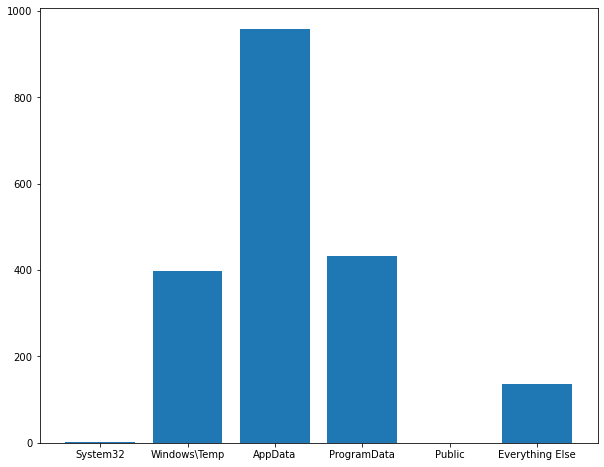

In [126]:
display(Markdown('''

## Counts for file writes to directories of interest

In this table, we see that files are written to a user's AppData directory in the majority of this data set. This can be broken down further by matching patterns to determine if the written file was written to the __root__ of AppData\\\(Roaming, Local, or LocalLow\) or to __subdirectories__ (e.x. AppData\\\(Roaming, Local, or LocalLow\)\\foo\\bar\\bad.exe).
'''))
figure( figsize=(10, 8))
plt.bar(["System32","Windows\\Temp","AppData","ProgramData","Public","Everything Else"], PathBarList)
plt.show()
display_side_by_side([PathMetrics,AppdataBreakdownDF])

In [100]:
display(Markdown('''
___
## Subset of entries for

- C:\\Windows\\System32
- C:\\ProgramData
- Misc Locations
'''))
display_side_by_side([ProgramdataDF.head(15),EverythingElseDF.head(15),System32DF.head(15)])


___
## Subset of entries for

- C:\Windows\System32
- C:\ProgramData
- Misc Locations


,ProgramData
0,c:\programdata\microsoft\windows\start menu\programs\startup\
1,c:\programdata\adobe\arm\reader_15.007.20033\acrordrdcupd1500920077.msp.uniwinnicrypt
2,c:\programdata\adobe\arm\reader_15.007.20033\how_fix_files.htm
3,c:\programdata\adobe\setup\{ac76ba86-7ad7-1033-7b44-ac0f074e4100}\acrordrdcupd1500820082.msp.uniwinnicrypt
4,c:\programdata\adobe\setup\{ac76ba86-7ad7-1033-7b44-ac0f074e4100}\data1.cab.uniwinnicrypt
5,c:\programdata\adobe\setup\{ac76ba86-7ad7-1033-7b44-ac0f074e4100}\how_fix_files.htm
6,c:\programdata\how_fix_files.htm
7,c:\programdata\microsoft help\how_fix_files.htm
8,c:\programdata\microsoft help\hx.hxn.uniwinnicrypt
9,c:\programdata\microsoft help\hx_1033_mkwd_k.hxw.uniwinnicrypt


In [127]:
display(Markdown('''
## Subset of Entries for 
- C:\\Users\\Public
- C:\\Users\\infected\\AppdData
- C:\\Windows\\Temp

In this round there were no file writes to the C:\\Users\\Public directory from any of the samples gathered, but that is not to say somewhere along the attach chain files were not written in the Public directory.
'''))
display_side_by_side([PublicDF.head(15),AppDataDF.head(15),TempDF.head(15)])


## Subset of Entries for 
- C:\Users\Public
- C:\Users\infected\AppdData
- C:\Windows\Temp

In this round there were no file writes to the C:\Users\Public directory from any of the samples gathered, but that is not to say somewhere along the attach chain files were not written in the Public directory.


,Public
,Appdata
0,c:\users\infected\appdata\local\
1,c:\users\infected\appdata\roaming\microsoft\windows\start menu\programs\startup\
2,c:\users\infected\appdata\roaming\inf.bmp
3,c:\users\infected\appdata\local\temp\5e62.tmp\5ea1.tmp\5ea2.bat
4,c:\users\infected\appdata\local\temp\5e62.tmp\aescrypt.exe
5,c:\users\infected\appdata\local\temp\7371.tmp\73b0.tmp\73b1.bat
6,c:\users\infected\appdata\local\temp\7371.tmp\aescrypt.exe
7,c:\users\infected\appdata\local\temp\5e62.tmp\photo.bmp
8,c:\users\infected\appdata\local\temp\5e62.tmp


In [128]:
display(Markdown('''
___

# Profiling Command Executions

One of the many things we need to draw meaningful conclusions is to grasp the process creations made by the samples. To start, we want to know where the child process images are running out of. What this provides is information concerning if attackers are running external tools or if they are living off of the land. 

'''))
System32Count = 0
AppdataCount = 0
EverythingElseCount =0
SysWow64Count=0
ProgramFilesCount=0
ProgramdataCount = 0   
PublicCount = 0
RelativeExecCount = 0

System32List = []
AppdataList = []
EverythingElseList = []
SysWow64List = []
ProgramFilesList = []
ProgramdataList = []
PublicList = []
EverythingElseList =[]
RelativeExecList = []

for i in CommandLines:
    i=i.lower()
    if re.search(r"^(\")?c:\\windows\\system32\\", i):
        System32Count += 1
        System32List.append(i)
    elif re.search(r"^(\")?c:\\users\\.+\\appdata", i):
        AppdataCount+=1
        AppdataList.append(i)
    elif re.search(r"^(\")?c:\\windows\\syswow64\\", i):
        SysWow64Count+=1
        SysWow64List.append(i)
    elif re.search(r"^(\")?c:\\(program files|%commonprogramfiles%)", i):
        ProgramFilesCount+=1
        ProgramFilesList.append(i)
    elif re.search(r"^(\")?c:\\programdata", i):
        ProgramdataCount+=1
        ProgramdataList.append(i)
    elif re.search(r"^(\")?c:\\users\\(%public%|public)", i):
        PublicCount+=1
        PublicList.append(i)
    elif re.search(r"^(\")?\w*\\\w+", i):
        RelativeExecCount+=1
        RelativeExecList.append(str(i))
    else:
        EverythingElseCount += 1
        EverythingElseList.append(i)

CommandBreakdownDF = pd.DataFrame(
    {
        "System32":[System32Count],
        "Appdata":[AppdataCount],
        "Public":[PublicCount],
        "SysWOW64":[SysWow64Count],
        "ProgramFiles":[ProgramFilesCount],
        "Programdata":[ProgramdataCount],
        "Relative Location":[RelativeExecCount],
        "Everything Else":[EverythingElseCount]
    },
    index=["Count"]
)
BarList = [System32Count,AppdataCount,PublicCount,SysWow64Count,ProgramFilesCount,ProgramdataCount,RelativeExecCount,EverythingElseCount]
SizeOfCommandsList = pd.DataFrame(
    {
    "Number of Commands":[len(CommandLines)]
    },
    index=["Count"]
)

System32ExecDF = pd.DataFrame(
    {
        "System32":System32List   
    }
)
AppDataExecDF = pd.DataFrame(
    {
        "AppData":AppdataList  
    }
)
ProgramFilesExecDF = pd.DataFrame(
    {
        "Program Files":ProgramFilesList  
    }
)
SysWOW64DF = pd.DataFrame(
    {
        "AppData":SysWow64List  
    }
)
ProgramDataExecDF = pd.DataFrame(
    {
        "ProgramData":ProgramdataList    
    }
)
EverythingElseExecDF = pd.DataFrame(
    {
        "Everything Else":EverythingElseList    
    }
)


___

# Profiling Command Executions

One of the many things we need to draw meaningful conclusions is to grasp the process creations made by the samples. To start, we want to know where the child process images are running out of. What this provides is information concerning if attackers are running external tools or if they are living off of the land. 




___
## Image locations for child processes

In this round, there were a large number of child processes executed out of relative locations. What this means is that we won't have any insight as to where that parent process is running out of, but despite that, we will see if any patterns can be derived from the information


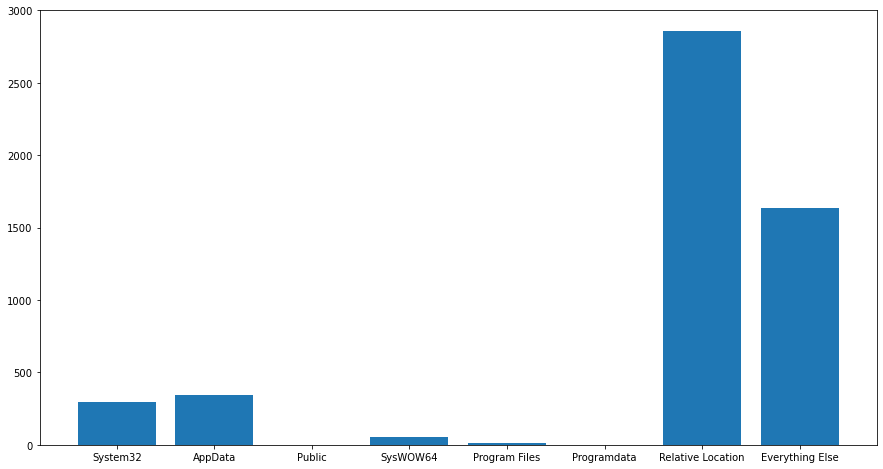

,System32,Appdata,Public,SysWOW64,ProgramFiles,Programdata,Relative Location,Everything Else
Count,293,345,1,52,13,0,2859,1637


In [129]:
display(Markdown('''
___
## Image locations for child processes

In this round, there were a large number of child processes executed out of relative locations. What this means is that we won't have any insight as to where that parent process is running out of, but despite that, we will see if any patterns can be derived from the information
'''))
figure( figsize=(15, 8))
plt.bar(["System32","AppData","Public","SysWOW64","Program Files","Programdata","Relative Location","Everything Else"], BarList)
plt.show()

CommandBreakdownDF


___
## Specific Processes

Child process locations can only offer a limited amount of information, but detections can still be build based on the little information we have. For the sake of space, a list of common child processes has already been compiled for ease of use.

- cmd.exe
- powershell.exe
- vssadmin.exe
- taskkill.exe
- bcedit.exe
- net.exe
- aescrypt.exe


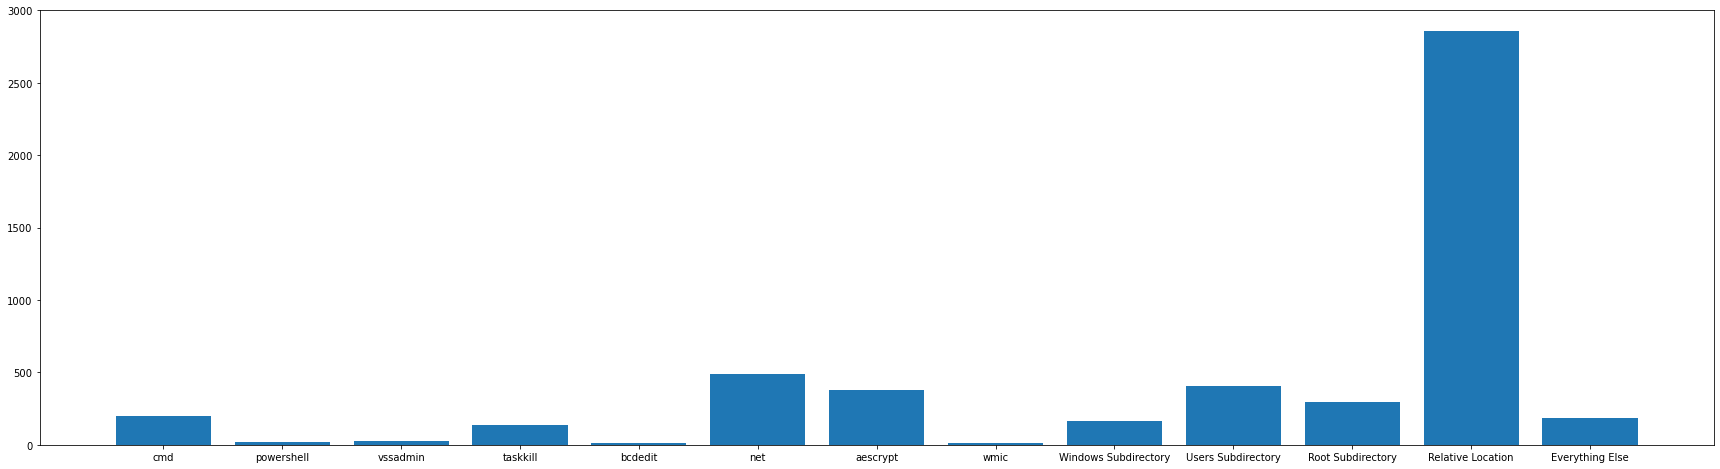

,cmd.exe,powershell.exe,vssadmin.exe,taskkill.exe,bcdedit.exe,net.exe,aescrypt.exe,wmic.exe,Windows Subdirectory (C:\Windows\),Users Subdirectory (C:\Users\infected\),Root Subdirectory (C:\),Relative path (bin\bad.exe),Everything Else
Count,200,21,26,137,13,488,381,14,166,404,296,2859,183


In [147]:
display(Markdown('''
___
## Specific Processes

Child process locations can only offer a limited amount of information, but detections can still be build based on the little information we have. For the sake of space, a list of common child processes has already been compiled for ease of use.

- cmd.exe
- powershell.exe
- vssadmin.exe
- taskkill.exe
- bcedit.exe
- net.exe
- aescrypt.exe
'''))

CmdCount = 0
PowerShellCount = 0
VssAdminCount = 0
TaskKillCount = 0
BcdeditCount = 0
NetCount = 0
AESCryptCount = 0
WmicCount = 0
WindowsSubdirCount = 0
UsersSubDirCount = 0
WindowsSubdirCount = 0
RootSubDirCount = 0
LeftoversCount = 0
RelativeExecCount = 0

CmdList = []
PowerShellList = []
VssAdminList = []
TaskKillList = []
BcdeditList = []
NetList = []
AESCryptList = []
WmicList = []
WindowsSubdirList = []
UsersSubDirList = []
WindowsSubdirList = []
RootSubDirList = []
LeftoversList = []
RelativeExecList = []

for i in CommandLines:
    i=i.lower()
    if re.search(r"^(\")?(c:\\windows\\(system32\\|syswow64\\).*)?(cmd|%comspec%)", i):
        CmdCount += 1
        CmdList.append(i)
    elif re.search(r"^(\")?(c:\\windows\\(system32\\|syswow64\\).*)?(powershell|pwsh)", i):
        PowerShellCount+=1
        PowerShellList.append(i)
    elif re.search(r"^(\")?(c:\\windows\\(system32\\|syswow64\\).*)?vssadmin", i):
        VssAdminCount+=1
        VssAdminList.append(i)
    elif re.search(r"^(\")?(c:\\windows\\(system32\\|syswow64\\).*)?taskkill", i):
        TaskKillCount+=1
        TaskKillList .append(i)
    elif re.search(r"^(\")?(c:\\windows\\(system32\\|syswow64\\).*)?bcdedit", i):
        BcdeditCount+=1
        BcdeditList.append(i)
    elif re.search(r"^(\")?(c:\\windows\\(system32\\|syswow64\\).*)?net", i):
        NetCount+=1
        NetList.append(i)
    elif re.search(r"^(\")?(c:\\windows\\(system32\\|syswow64\\).*)?aescrypt", i):
        AESCryptCount+=1
        AESCryptList.append(i)
    elif re.search(r"^(\")?(c:\\windows\\(system32\\|syswow64\\).*)?wmic", i):
        WmicCount+=1
        WmicList.append(i)
    elif re.search(r"^(\")?\w*\\\w*", i):
        RelativeExecCount+=1
        RelativeExecList.append(i)
    elif re.search(r"(\")?c:\\windows", i):
        WindowsSubdirCount+=1
        WindowsSubdirList.append(i)
    elif re.search(r"(\")?c:\\users\\.*\\", i):
        UsersSubDirCount+=1
        UsersSubDirList.append(i)
    elif re.search(r"(\")?c:\\\w*", i):
        if re.search(r"program files",i):
            pass
        else:      
            RootSubDirCount +=1
            RootSubDirList.append(i)
    else:
        LeftoversCount += 1
        LeftoversList.append(i)

CommandBreakDownDF = pd.DataFrame(
    {
        "cmd.exe":[CmdCount],
        "powershell.exe":[PowerShellCount],
        "vssadmin.exe":[VssAdminCount],
        "taskkill.exe":[TaskKillCount],
        "bcdedit.exe":[BcdeditCount],
        "net.exe":[NetCount],
        "aescrypt.exe":[AESCryptCount],
        "wmic.exe":[WmicCount],
        "Windows Subdirectory (C:\\Windows\\)":[WindowsSubdirCount],
        "Users Subdirectory (C:\\Users\\infected\\)":[UsersSubDirCount],
        "Root Subdirectory (C:\\)":[RootSubDirCount],
        "Relative path (bin\\bad.exe)":[RelativeExecCount],
        "Everything Else":[LeftoversCount],
    },
    index=["Count"]
)

CmdDF = pd.DataFrame(
    {
        "cmd.exe":CmdList    
    }
)
PowerShellDF = pd.DataFrame(
    {
        "powershell.exe":PowerShellList    
    }
)
VssAdminDF = pd.DataFrame(
    {
        "vssadmin.exe":VssAdminList    
    }
)
BcdeditDF = pd.DataFrame(
    {
        "bcdedit.exe":BcdeditList   
    }
)
NetDF = pd.DataFrame(
    {
        "net.exe":NetList   
    }
)
WmicDF = pd.DataFrame(
    {
        "wmic.exe":WmicList    
    }
)
AESCryptDF = pd.DataFrame(
    {
        "aescrypt.exe":AESCryptList    
    }
)
RelativeExecDF = pd.DataFrame(
    {
        "Relative Exec":RelativeExecList   
    }
)
WindowsSubdirDF = pd.DataFrame(
    {
        "Windows Subdirectory":WindowsSubdirList   
    }
)
UserSubdirDF = pd.DataFrame(
    {
        "Users Subdirectory":UsersSubDirList    
    }
)
RootSubdirDF = pd.DataFrame(
    {
        "Root Subdirectory":RootSubDirList   
    }
)
LeftoverDF = pd.DataFrame(
    {
        "EverythingElse":LeftoversList    
    }
)
figure(figsize=(30, 8))
BreakdownGraphList = [CmdCount,PowerShellCount,VssAdminCount,TaskKillCount,BcdeditCount,NetCount,AESCryptCount,WmicCount,WindowsSubdirCount,UsersSubDirCount,RootSubDirCount,RelativeExecCount,LeftoversCount]
x = ["cmd","powershell","vssadmin","taskkill","bcdedit","net","aescrypt","wmic","Windows Subdirectory","Users Subdirectory","Root Subdirectory","Relative Location","Everything Else"]
plt.bar(x, BreakdownGraphList)
plt.show()
CommandBreakDownDF

In [131]:
display(Markdown('''
___
## Cmd.exe, Vssadmin.exe, net.exe, bcdedit.exe

These commands are often executed for code execution, disabling system integrity and restoration controls, and profiling a host or environment. In the latter tables \(vssadmin, net, and bcdedit\)
several different patterns will help set up the detections

### vssadmin\n
- ```delete shadows (\/all(\s)|\/quiet(\s)?)+?```

### net _(note: the better detection is to look for multiple events where net stop is used)_
- ```net(\.exe)? stop \w+```

### bcdedit
- ```(recoveryenabled no|ignoreallfailures)+```
'''))

display_side_by_side([CmdDF.head(25),VssAdminDF.head(25),NetDF.head(25),BcdeditDF.head(25)])


___
## Cmd.exe, Vssadmin.exe, net.exe, bcdedit.exe

These commands are often executed for code execution, disabling system integrity and restoration controls, and profiling a host or environment. In the latter tables \(vssadmin, net, and bcdedit\)
several different patterns will help set up the detections

### vssadmin

- ```delete shadows (\/all(\s)|\/quiet(\s)?)+?```

### net _(note: the better detection is to look for multiple events where net stop is used)_
- ```net(\.exe)? stop \w+```

### bcdedit
- ```(recoveryenabled no|ignoreallfailures)+```


,cmd.exe
0,"""%comspec%"" /c vssadmin.exe delete shadows /all /quiet"
1,cmd.exe /c vssadmin.exe delete shadows /all /quiet
2,"""c:\windows\system32\cmd.exe"" /c vssadmin.exe delete shadows /all /quiet"
3,c:\windows\system32\cmd.exe /c vssadmin.exe delete shadows /all /quiet
4,c:\windows\system32\cmd.exe
5,c:\windows\system32\cmd.exe /c echo 75bb576d00d3ef97
6,c:\windows\system32\cmd.exe /c ren c:\users\infected\appdata\local\temp\75bb57 7za.exe
7,"c:\windows\system32\wbem\wmic.exe process call create ""cmd.exe /c vssadmin.exe delete shadows /all /quiet & bcdedit.exe /set {default} recoveryenabled no & bcdedit.exe /set {default} bootstatuspolicy ignoreallfailures"""
8,cmd.exe /c vssadmin.exe delete shadows /all /quiet & bcdedit.exe /set {default} recoveryenabled no & bcdedit.exe /set {default} bootstatuspolicy ignoreallfailures
9,"""c:\windows\system32\cmd.exe"" /c echo 75bb576d00d3ef97"


In [132]:
display(Markdown('''
___
## Relative location, User subdirectory, Windows subdirectory

Now we can take a close look at what processes are started from a relative location. In most of these cases, we see that hunting for patterns where the command line begins with ```bin```.
- ```bin\\(\w|-|_)+\.exe.+appdata(local\\temp)?```

We can also search for similar patterns for the user's subdirectory where a process in appdata is explicitly referencing another file in appdata or another case when 7za.exe is unzipping a file into appdata.
- ```c:\\users(\\.*\\)+(\w+\.exe|7za\.exe|is32bit) (--config|--dll)?(appdata(local\\temp)?)```
'''))
display_side_by_side([RelativeExecDF.head(15),UserSubdirDF.head(25),WindowsSubdirDF.head(25)])


___
## Relative location, User subdirectory, Windows subdirectory

Now we can take a close look at what processes are started from a relative location. In most of these cases, we see that hunting for patterns where the command line begins with ```bin```.
- ```bin\(\w|-|_)+\.exe.+appdata(local\temp)?```

We can also search for similar patterns for the user's subdirectory where a process in appdata is explicitly referencing another file in appdata or another case when 7za.exe is unzipping a file into appdata.
- ```c:\users(\.*\)+(\w+\.exe|7za\.exe|is32bit) (--config|--dll)?(appdata(local\temp)?)```


,Relative Exec
0,bin\is32bit.exe -f c:\users\a4148~1.mon\appdata\local\temp\b3ed8b695d7c3a6ffa4e41b2831787cf.exe
1,bin\hxchlsddm.exe --app c:\users\a4148~1.mon\appdata\local\temp\b3ed8b695d7c3a6ffa4e41b2831787cf.exe --only-start --curdir c:\users\a4148~1.mon\appdata\local\temp
2,bin\is32bit.exe -p 276
3,bin\hxchlsddm.exe --resume-thread --pid 276 --tid 1660 --apc --dll c:\fktqykcyppizre.dll --config c:\users\a4148~1.mon\appdata\local\temp\tmptezk9o
4,bin\is32bit.exe -n cmd.exe
5,bin\zsvu.exe --dll c:\axgweftczybivufwjg.dll --config c:\users\a4148~1.mon\appdata\local\temp\tmpefhsgy --pid 2164 --apc --tid 2168
6,bin\is32bit.exe -n vssadmin.exe
7,bin\zsvu.exe --dll c:\axgweftczybivufwjg.dll --config c:\users\a4148~1.mon\appdata\local\temp\tmp8dskeo --pid 2268 --apc --tid 2272
8,bin\is32bit.exe -p 2268
9,bin\zsvu.exe --pid 2268 --dump c:\users\a4148~1.mon\appdata\local\temp\tmpy7w9hs


In [133]:
display(Markdown('''
___
## Root Subdirectory execution and misc commands

Based on the same set here, there is not a lot to go on for in terms of pattern matching, but if one were to extend the misc commands list (Everything Else), more detections and lists could be added for future use.
'''))

display_side_by_side([RootSubdirDF.tail(25),LeftoverDF.head(25)])


___
## Root Subdirectory execution and misc commands

Based on the same set here, there is not a lot to go on for in terms of pattern matching, but if one were to extend the misc commands list (Everything Else), more detections and lists could be added for future use.


,Root Subdirectory
271,c:\djnxenfq\bin\ufkktioqr.exe inject 804 2636 \xsapzinygp.dll
272,c:\djnxenfq\bin\ufkktioqr.exe inject 2628 2852 \xsapzinygp.dll
273,c:\djnxenfq\bin\ufkktioqr.exe inject 1068 2712 \xsapzinygp.dll
274,c:\djnxenfq\bin\ufkktioqr.exe inject 1316 1276 \xsapzinygp.dll
275,c:\djnxenfq\bin\ufkktioqr.exe inject 3080 3084 \xsapzinygp.dll
276,c:\djnxenfq\bin\ufkktioqr.exe inject 3160 3164 \xsapzinygp.dll
277,c:\djnxenfq\bin\ufkktioqr.exe inject 3316 3320 \xsapzinygp.dll
278,c:\djnxenfq\bin\ufkktioqr.exe inject 3468 3472 \xsapzinygp.dll
279,c:\djnxenfq\bin\ufkktioqr.exe inject 3576 3580 \xsapzinygp.dll
280,c:\djnxenfq\bin\ufkktioqr.exe inject 3732 3736 \xsapzinygp.dll
